In [2]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

#%matplotlib inline
#%config InlineBackend.figure_format='retina'

#sns.set(style='whitegrid', palette'muted', font_scale=1.2)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv('/Users/arijitmondal/workspace/app-review-sentiment-analysis-using-bert/data/app_review.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15259 entries, 0 to 15258
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15259 non-null  object
 1   userName              15259 non-null  object
 2   userImage             15259 non-null  object
 3   content               15258 non-null  object
 4   score                 15259 non-null  int64 
 5   thumbsUpCount         15259 non-null  int64 
 6   reviewCreatedVersion  13113 non-null  object
 7   at                    15259 non-null  object
 8   replyContent          7390 non-null   object
 9   repliedAt             7390 non-null   object
 10  sortOrder             15259 non-null  object
 11  appId                 15259 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.4+ MB
None


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEdg6yUOvcZHEm6vmnCD7vXQW7wuauIJaKhKtw...,Uchihasocksy,https://play-lh.googleusercontent.com/-jhjI7vI...,Was simply looking for a widget that could syn...,1,0,5.10.0.8,2021-03-05 00:37:04,Any.do’s Calendar Integration syncs events to ...,2021-03-07 10:03:08,most_relevant,com.anydo
1,gp:AOqpTOHTeNGxl9Zhlz-BM6ybraEsnVg0BLDubF8E_fQ...,kelvin ho,https://play-lh.googleusercontent.com/-rSnBD4Y...,Very very bad experience with the management! ...,1,5,5.10.0.8,2021-02-26 04:17:49,"Hi Kelvin, we've checked our records and could...",2021-02-28 09:36:51,most_relevant,com.anydo
2,gp:AOqpTOH5OkwJH-nRT4nopD_JNTIYpWs1xWzOsFE-pn7...,Charles Green,https://play-lh.googleusercontent.com/a-/AOh14...,"Ugh! After years of using this app, I am so ve...",1,10,5.9.0.2,2021-02-17 19:10:03,"From checking our records, the issue you've re...",2021-02-18 11:22:00,most_relevant,com.anydo
3,gp:AOqpTOG4LKg25ejg1Hw1TWs6_gIXhpwJRZZpXssMygx...,Andi Tan,https://play-lh.googleusercontent.com/-vozop-l...,I'm a new user. I think this app's great. I tr...,1,13,5.9.0.2,2021-02-07 11:54:54,The Quick-add bar on the device's Notification...,2021-02-09 09:19:18,most_relevant,com.anydo
4,gp:AOqpTOGQ7NShvSVr9Vqz67MSeTN_3rkBuYtQRtsyAo5...,Drew Dayman,https://play-lh.googleusercontent.com/a-/AOh14...,Bought it to use with Alexa. After multiple at...,1,1,5.9.0.2,2021-02-12 20:35:18,NaN,NaN,most_relevant,com.anydo


/Users/arijitmondal/anaconda3/envs/appReviewEnv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Review Score')

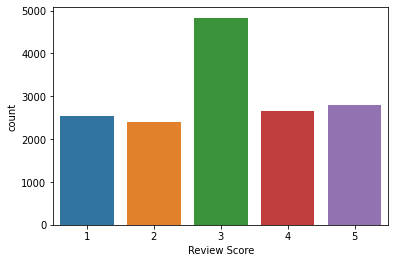

In [4]:
sns.countplot(df.score)
plt.xlabel('Review Score')

In [5]:
def to_sentiment(ratings):
    rating = int(ratings)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
df['sentiment'] = df.score.apply(to_sentiment)

/Users/arijitmondal/anaconda3/envs/appReviewEnv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentiment Score')

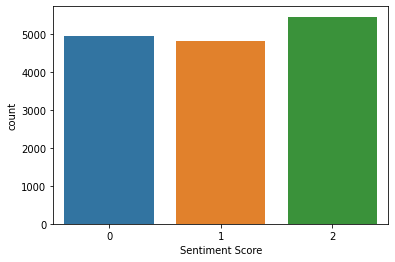

In [6]:
sns.countplot(df.sentiment)
plt.xlabel('Sentiment Score')

## Data Preprocessing

In [7]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [8]:
encoding = tokenizer.encode_plus(
    text, 
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

NameError: name 'text' is not defined

In [9]:
from torch.utils.data import Dataset


class GPReviewDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])
        
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )

        return {
            'input_ids' : encoding['input_ids'],
            'attention_mask' : encoding['attention_mask'],
            'targets' : torch.tensor(self.target[item], dtype=torch.long) # type long for classification problem
        }

In [10]:
import transformers
import os
from torch import nn

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [12]:
bert_model = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidde_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

NameError: name 'encoding' is not defined

In [5]:
bert_model.config.hidden_size

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

## Sentiment classifier

In [11]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(os.getenv('MODEL'))
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
        )
        output = self.drop(pooled_output)
        output = self.out(output)

        return self.softmax(output)

In [12]:
model = SentimentClassifier(len(class_names))
model = model.to(os.getenv('GPU'))

NameError: name 'class_names' is not defined